<a href="https://colab.research.google.com/github/danabez1/ai-agents-for-beginners/blob/main/CheckPointHomeAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checkpoint Data Scientist Home Assignment

Retrieval System:
- Your task is to build a retriever and use it to return the relevant document ids given a
question

# Load Packages

In [ ]:
import random
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score, roc_curve

In [ ]:
pd.set_option('display.max_colwidth', 100)

In [ ]:
# After installing spacy, download the English model if needed:
# python -m spacy download en_core_web_sm
# Load spaCy English model
nlp = spacy.load('en_core_web_sm')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !python --version

In [ ]:
# !pip freeze > requirements.txt
# from google.colab import files
# files.download('requirements.txt')

# Inspect input files

In [ ]:
question_file_path = '/content/sample_data/questions.json'
doc_file_path = '/content/sample_data/docs_text.json'

In [ ]:
df_questions = pd.read_json(question_file_path)
df_questions.shape

(30, 2)

In [ ]:
df_questions.sample(5)

,question,doc_ids
18,How do I troubleshoot a VOIP issue?,"[sk95369, sk65072]"
5,how to collect cpinfo of endpoint client?,[sk90445]
11,How to block DNS trap?,"[sk74060, sk92224]"
16,how to create exclusion for anti-malware blade?,[sk122706]
28,What are supported operating systems for endpoint client,"[sk181265, sk181103, sk170198, sk117536]"


In [ ]:
df_docs = pd.read_json(doc_file_path)
df_docs.shape

(109, 2)

In [ ]:
df_docs.sample(5)

,doc_id,text
39,sk98489,Solution:\nDo the procedure below if the URL Filtering database miscategorizes a URL. This proce...
31,sk101690,Solution:\nTable of Contents:\n- Introduction \n- Limitations \n- Important Notes \n- Pr...
75,sk43807,Symptoms:\n- Anti-Virus / URL Filtering / IPS update fails on the Standby member of ClusterXL be...
91,sk119232,Solution:\nThis article provides summary tables with threshold values for hardware sensors for C...
48,sk100571,"Symptoms:\n- When browsing to a block site, the site gets blocked however the page does not redi..."


- Explore specific case

In [ ]:
# sample a single case
RANDOM_SEED = 20
random_sample = df_questions.sample(1, random_state=RANDOM_SEED)
random_sample

,question,doc_ids
13,What are these RAD errors?,"[sk90422, sk106623]"


In [ ]:
# Print question and 1 example of answer document
sample_doc_ids = random_sample['doc_ids'].iloc[0]
print(f"Question: {random_sample['question'].iloc[0]}")
print(f"Solution docs: {sample_doc_ids}")
random.seed(RANDOM_SEED)
sample_solution = random.choice(sample_doc_ids)
print(f"Solution Document IDs: {sample_solution}")
print()
print(df_docs[df_docs['doc_id'] == sample_solution]['text'].iloc[0])

Question: What are these RAD errors?
Solution docs: ['sk90422', 'sk106623']
Solution Document IDs: sk90422

Solution:
This article can be used to troubleshoot the following issue:
-   RAD process on Security Gateway constantly consumes CPU at 100%. 
-   SmartView Tracker / SmartLog shows multiple " internal system error occurred ..." logs from Application Control / URL Filtering.
Table of Contents: 
-   When is it recommended to enlarge the cache limit? 
-   How to check the current number of entries in the URL Filtering cache? 
-   How to check the current limit of the URL Filtering cache? 
-   How to clear URL Filtering kernel cache? 
-   How to modify the limit of the URL Filtering cache? 
-   Related solutions 

(1) When is it recommended to enlarge the cache limit? 
When the cache is full, about 20% of the entries are cleared. If this occurs repeatedly, then you should consider enlarging the cache size. The URL Filtering cache limit default value is 20 000, which is usually enough

* The dataset includes technical documents (close domain)

# EDA of question text

* Legnth (count words)
* Clean text for EDA purpose
* Empty docs
* Duplicates
* Frequent words
* Rare words


,word_count
count,109.000000
mean,1982.522936
std,1818.928900
min,103.000000
25%,361.000000
50%,1224.000000
75%,3821.000000
90%,5189.000000
95%,5189.000000
99%,5189.000000


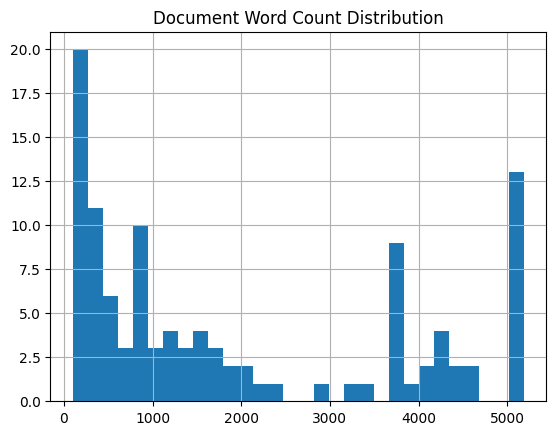

In [ ]:
### Count Words ###
df_text = df_docs[['text']].copy()
df_text['word_count'] = df_text['text'].apply(lambda x: len(x.split()))

# Summary statistics
display(df_text['word_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# Plot histograms (optional)
df_text['word_count'].hist(bins=30)
plt.title("Document Word Count Distribution")
plt.show()

* The text distribution is not normalized, there are documnets with long text (> 2000), while other with shorter text (< 300)
* This should also affect the way we embed the text for indexing

--> It is suggested to inspect document with long text by domain expert, to check for any unusual / redundant / spam text and create code to clean such text, if found

In [ ]:
# # Sample random document with long text to check for any unusual patterns
# long_text_idx = df_text[df_text['word_count'] > 2000].index
# print(df_docs.iloc[long_text_idx]['text'].sample(1).iloc[0])

* Clean text for further inspection

In [ ]:
%%time
# Normalize text for inspection

def clean_text(text):
    # Convert to string (in case of NaN or non-string)
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove special characters and punctuation (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize with spaCy and lemmatize, remove stopwords and short tokens
    doc = nlp(text)
    words = [
        token.lemma_ for token in doc
        if token.lemma_ not in ENGLISH_STOP_WORDS
        and token.is_alpha
        and len(token.lemma_) > 1  # remove very short words
    ]

    # Join back into cleaned text
    cleaned_text = ' '.join(words)
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text


df_text['text_normalized'] = df_text['text'].apply(clean_text)
df_text[['text', 'text_normalized']].sample(1)

CPU times: user 40 s, sys: 1.64 s, total: 41.6 s
Wall time: 45 s


,text,text_normalized
57,Solution:\nMalware DNS Trap identifies compromised clients that try to access known malicious do...,solution malware dns trap identifie compromise client try access known malicious domain feature ...


In [ ]:
### Empty docs ###
# Strip whitespace and check empty
df_text['text_stripped'] = df_text['text_normalized'].astype(str).str.strip()

# Empty or only whitespace
empty_docs = df_text[df_text['text_stripped'] == '']

print(f"Number of empty/whitespace-only documents: {len(empty_docs)}")

Number of empty/whitespace-only documents: 0


In [ ]:
df_docs.sample(1)

,doc_id,text
95,sk119232,Solution:\nThis article provides summary tables with threshold values for hardware sensors for C...


In [ ]:
### Duplicate IDs / Duplicate Text ###

duplicate_ids = df_docs[df_docs.duplicated(subset='doc_id', keep=False)]

print(f"Number of duplicate document IDs: {len(duplicate_ids)}")
duplicate_ids[['doc_id', 'text']].head(2)

Number of duplicate document IDs: 24


,doc_id,text
84,sk119232,Solution:\nThis article provides summary tables with threshold values for hardware sensors for C...
85,sk119232,Solution:\nThis article provides summary tables with threshold values for hardware sensors for C...


* There are 24 duplicte documents, to be removed

In [ ]:
### Most Frequent Words (excluding stopwords) ###
TOP_FREQ_EDA = 20
# Tokenize all texts and remove stopwords
all_words = [
    word.lower() for text in df_text['text_normalized']
    for word in text.split()
    if word.lower() not in ENGLISH_STOP_WORDS
]

# Count word frequencies
word_freq = Counter(all_words)

# Top 20 frequent words
for top_i, (word, n_count) in enumerate(word_freq.most_common(TOP_FREQ_EDA)):
  print(f"TOP: {top_i + 1}| WORD: {word} - COUNT: {n_count:,}")

TOP: 1| WORD: na - COUNT: 1,796
TOP: 2| WORD: security - COUNT: 1,675
TOP: 3| WORD: volt - COUNT: 1,599
TOP: 4| WORD: fan - COUNT: 1,490
TOP: 5| WORD: gateway - COUNT: 1,290
TOP: 6| WORD: speed - COUNT: 1,212
TOP: 7| WORD: cpu - COUNT: 1,114
TOP: 8| WORD: voltage - COUNT: 1,018
TOP: 9| WORD: server - COUNT: 968
TOP: 10| WORD: rpm - COUNT: 950
TOP: 11| WORD: file - COUNT: 933
TOP: 12| WORD: check - COUNT: 824
TOP: 13| WORD: power - COUNT: 806
TOP: 14| WORD: management - COUNT: 749
TOP: 15| WORD: sk - COUNT: 727
TOP: 16| WORD: support - COUNT: 672
TOP: 17| WORD: point - COUNT: 634
TOP: 18| WORD: threshold - COUNT: 577
TOP: 19| WORD: temperature - COUNT: 535
TOP: 20| WORD: use - COUNT: 524


In [ ]:
### Most Rare Words (appearing only once) ###
rare_words = [word for word, freq in word_freq.items() if freq == 1]

print(f"Number of rare words: {len(rare_words):,}")
print('\n'.join(rare_words[:10]))

Number of rare words: 1,662
schema
miniui
technique
scheduled
windowslist
delayed
unprompte
uninstalling
epamservice
lenovo


# EDA Quesion file



*   Questions length
*   Distribution of documents



In [ ]:
### Count Words ###
df_ques_text = df_questions[['question']].copy()
df_ques_text['word_count'] = df_ques_text['question'].apply(lambda x: len(x.split()))

# Summary statistics
print('Words count statistics')
df_ques_text['word_count'].describe()

Words count statistics


,word_count
count,30.000000
mean,7.700000
std,2.768667
min,4.000000
25%,6.000000
50%,7.000000
75%,9.000000
max,17.000000


* question are short compared to documents length
* no unusual question length

In [ ]:
### Statistics of documents ###
df_questions['n_docs'] = df_questions['doc_ids'].apply(len)
df_questions['n_docs'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

,n_docs
count,30.00000
mean,2.10000
std,1.66816
min,1.00000
25%,1.00000
50%,1.50000
75%,2.00000
90%,4.10000
95%,6.10000
99%,7.00000


* The number of ground truth documents per question varies, with ~50% have 1-2 documents per query
* This may impact the evaluation metrics - as questions with only 1 document are likely to increase precision and recall, while questions with higher documents is expected to get lower recall

# Indexing

There are two main appriaches for indexing:

1.  BM25 / TFIDF - embedding vector is based on words frequency
2.  Dense Embedding (Sentence-BERT)

**Selected Method:**
- I decided to use Dense Embedding, specificly SBERT, for index embedding
-  Dense embedding captures semantic meaning, compared to B25M/TFIDF which are based on shared key words
- In the current task, documents are long and might include redundant information, while the questions are short and an embedding-based methods that computes an overall semantic representation is an advantage
- SBERT can handle abbrevation and phrases
- BM25/TFIDF is more prone to
- Can be applied with FAISS or other fast approximate search methods

- Main disadvantage -
  - SBERT is more computational expensive (requires GPU or optimized CPU), also the index (embedding) size might requires higher memroy
  - Harder to debug compared to a method that relays on key-words
  - Out-of-the-box SBERT may not handle highly technical terms or domain specific well, might need fine-tuning, which is not a simple task


## Preprocess the data

In [ ]:
### Remove Duplicates
df_indexing = df_docs.drop_duplicates(subset='doc_id', keep='first').copy()
n_removed_docs = len(df_docs) - len(df_indexing)
print(f"Initial dataset size: {len(df_docs):,}, final size: {len(df_indexing):,} (total removed docs: {n_removed_docs:,})")

Initial dataset size: 109, final size: 88 (total removed docs: 21)


## Apply SBERT

* SBERT is 256 tokens
* One method to handle long texts, is to chunked that data to a max of 256 and averaged it accross the document

In [ ]:
%%time
CHUNCK_SIZE = 256
model = SentenceTransformer('all-MiniLM-L6-v2')  # SBERT

def split_into_chunks(text, max_words=CHUNCK_SIZE):
    words = text.split()
    return [' '.join(words[i:i+max_words]) for i in range(0, len(words), max_words)]

def encode_long_doc(text):
    chunks = split_into_chunks(text)
    embeddings = model.encode(chunks)
    return np.mean(embeddings, axis=0)  # Average embedding

# Compute embeddings for all documents
df_indexing['embedding'] = df_indexing['text'].apply(encode_long_doc)

CPU times: user 1min 10s, sys: 2.39 s, total: 1min 12s
Wall time: 1min 15s


# Retrieval

Main approaches:
- Cosine similarity
- FAISS indexing

I decided to use Cosine similarity:
- Advantages:
  - accuracy is high
  - easy to apply
  - score can be directly use to create threshold
- Disadvantage:
  - less scable compared to FAISS
  - runs slow for large datasets
  - requires higher memory usage
  

In [ ]:
def retrieve_doc(query, doc_embeddings):
  # Compute embedding for the query
  query_embedding = model.encode(query)
  # Compute cosine similarity between query and all docs
  similarities = cosine_similarity([query_embedding], doc_embeddings)[0]
  # Sort descenting order
  sorted_doc_indices = similarities.argsort()[::-1]
  sorted_docs_scores = similarities[sorted_doc_indices]
  return sorted_doc_indices, sorted_docs_scores

def get_docs_similarity(query, df_index_docs):
  # returns top_k documets ids and cosine similarity score
  doc_embeddings = df_index_docs['embedding'].tolist()
  sorted_doc_indices, sorted_docs_score = retrieve_doc(query, doc_embeddings)
  # Retrieve top-K document IDs and scores
  top_k_docs = df_index_docs.iloc[sorted_doc_indices]['doc_id'].tolist()
  return top_k_docs, sorted_docs_score

In [ ]:
df_retrieval = df_questions.copy()
df_retrieval = df_retrieval.rename(columns={'doc_ids': 'ground_truth_ids', 'n_docs': 'n_ground_truth'})
df_retrieval[['retrieve_doc_ids', 'retrieve_doc_score']] = df_retrieval.apply(lambda x: get_docs_similarity(x['question'], df_indexing), axis=1, result_type='expand')

In [ ]:
df_retrieval.sample(2)

,question,ground_truth_ids,n_ground_truth,retrieve_doc_ids,retrieve_doc_score
21,What are the supported Linux distributions for endpoint client?,[sk170198],1,"[sk117536, sk181103, sk181265, sk170198, sk90560, sk178307, sk116590, sk158572, sk113113, sk9574...","[0.4795104, 0.45487496, 0.4434538, 0.4020443, 0.33596346, 0.3240428, 0.30980253, 0.30963296, 0.3..."
2,Why are sites not working after enabling HTTPS inspection?,"[sk112214, sk112066, sk108202, sk105559, sk104562, sk11088, sk112214]",7,"[sk108840, sk108202, sk112214, sk112066, sk104562, sk103522, sk100281, sk64521, sk165094, sk9138...","[0.6229347, 0.54450977, 0.5017652, 0.48966005, 0.46892163, 0.42983973, 0.425245, 0.4067729, 0.40..."


# Evaluation

* Common retrieval metrics:
  - Recall@k: Fraction of relevant (ground-truth) doc_ids found in the top-k retrieved
  - Precision@k: Fraction of top-k retrieved doc_ids that are relevant
  - MAP@k	(Mean Average Precision at k): Considers ranking of relevant docs
  - Hit@k: Whether at least one relevant doc_id is in top-k

* Adding threshold:
  - to improve precision, a threshold can be applied to exclude documents with low similarity score
  - In order to set a threshold I first split the question to VAL and TEST
  - I evaluate and compared retrieval metrics on TEST dataset, with and without threshold

## Split Questions

In [ ]:
df_retrieval['n_ground_truth_group'] = pd.cut(df_retrieval['n_ground_truth'], bins=[ 0, 1, 2, 10])

In [ ]:
# stratify by n_ground_truth_group
df_val, df_test = train_test_split(df_retrieval, test_size=10, stratify=df_retrieval['n_ground_truth_group'], random_state=42)
df_val.shape, df_test.shape

((20, 6), (10, 6))

In [ ]:
df_val['n_ground_truth_group'].value_counts(normalize=True).mul(100).round(1)

,proportion
n_ground_truth_group,
"(0, 1]",50.0
"(1, 2]",25.0
"(2, 10]",25.0


In [ ]:
df_test['n_ground_truth_group'].value_counts(normalize=True).mul(100).round(1)

,proportion
n_ground_truth_group,
"(0, 1]",50.0
"(1, 2]",30.0
"(2, 10]",20.0


## Evaluation Top-K on Val set (No threshood)

In [ ]:
def evaluate_retrieval_multi_k_df(df, k_values=[1, 3, 5, 7], threshold = 0.0):
    rows = []

    for k in k_values:
        recall_scores = []
        precision_scores = []
        ap_scores = []
        hit_scores = []
        mrr_scores = []

        for _, row in df.iterrows():
            gt_set = set(row['ground_truth_ids'])  # ground truth doc IDs
            retrieved_docs = row['retrieve_doc_ids'][:k]  # top-k retrieved
            retrieved_scores = row['retrieve_doc_score'] # top-k retrieved similary score

            # Filter based on threshold
            filtered = [(doc_id, score) for doc_id, score in zip(retrieved_docs, retrieved_scores) if score >= threshold]

            # Select top-k after threshold filtering
            filtered_docs = [doc_id for doc_id, _ in filtered[:k]]

            hits = [1 if doc_id in gt_set else 0 for doc_id in filtered_docs]

            precision = sum(hits) / k
            recall = sum(hits) / len(gt_set) if gt_set else 0.0
            hit = 1.0 if sum(hits) > 0 else 0.0

            ap_sum, correct = 0.0, 0
            for i, doc_id in enumerate(filtered_docs):
                if doc_id in gt_set:
                    correct += 1
                    ap_sum += correct / (i + 1)
            ap = ap_sum / len(gt_set) if gt_set else 0.0


            reciprocal_rank = 0.0
            for i, doc_id in enumerate(filtered_docs):
                if doc_id in gt_set:
                    reciprocal_rank = 1.0 / (i + 1)
                    break

            precision_scores.append(precision)
            recall_scores.append(recall)
            hit_scores.append(hit)
            ap_scores.append(ap)
            mrr_scores.append(reciprocal_rank)

        # Append row with average metrics for current k
        rows.append({
            'top_k': k,
            'recall': np.mean(recall_scores),
            'precision': np.mean(precision_scores),
            'hit': np.mean(hit_scores),
            'MAP': np.mean(ap_scores),
            'MRR': np.mean(mrr_scores)
        })

    results_df = pd.DataFrame(rows)
    return results_df

In [ ]:
metrics_df = evaluate_retrieval_multi_k_df(df_val, k_values=[1, 2, 3, 5, 7, 10])
metrics_df = metrics_df.set_index('top_k')
metrics_df

,recall,precision,hit,MAP,MRR
top_k,,,,,
1,0.497500,0.800000,0.80,0.497500,0.800000
2,0.653333,0.575000,0.85,0.628333,0.825000
3,0.767500,0.466667,0.90,0.700833,0.841667
5,0.850000,0.320000,0.95,0.743333,0.851667
7,0.883333,0.242857,0.95,0.756429,0.851667
10,0.883333,0.170000,0.95,0.756429,0.851667


Discussion:
- The overall results are moderate (not good, not bad)
- Recall and precision can be impacted by the number of n_ground truth  - below is an analysis per n-docs group type
- Hit score for K = 3 - in 90% of the cases, at least 1 document is relevant
- MAP is not impacted by n_ground truth, it reflects the rank of  relevant retrieved documents - the results are moderate and only improves towards K=3, meaning that some relevant docs are missed or poorly ranked
- MRR, like Hit score, is good, indicating that the first relevant document is ranked at good position

* Inspect by group of n_ground_truth_group

In [ ]:
for group, df_group in df_val.groupby('n_ground_truth_group'):
  print(f"N ground truth documents: {str(group)}")
  print(f"total questions - {len(df_group):,}")
  metrics_df = evaluate_retrieval_multi_k_df(df_group, k_values=[1, 2, 3, 5, 7])
  metrics_df = metrics_df.set_index('top_k')
  display(metrics_df)

N ground truth documents: (0, 1]
total questions - 10


,recall,precision,hit,MAP,MRR
top_k,,,,,
1,0.6,0.600000,0.6,0.600000,0.600000
2,0.7,0.350000,0.7,0.650000,0.650000
3,0.8,0.266667,0.8,0.683333,0.683333
5,0.9,0.180000,0.9,0.703333,0.703333
7,0.9,0.128571,0.9,0.703333,0.703333


N ground truth documents: (1, 2]
total questions - 5


,recall,precision,hit,MAP,MRR
top_k,,,,,
1,0.5,1.000000,1.0,0.500000,1.0
2,0.7,0.700000,1.0,0.700000,1.0
3,0.8,0.533333,1.0,0.766667,1.0
5,0.8,0.320000,1.0,0.766667,1.0
7,0.8,0.228571,1.0,0.766667,1.0


N ground truth documents: (2, 10]
total questions - 5


,recall,precision,hit,MAP,MRR
top_k,,,,,
1,0.290000,1.000000,1.0,0.290000,1.0
2,0.513333,0.900000,1.0,0.513333,1.0
3,0.670000,0.800000,1.0,0.670000,1.0
5,0.800000,0.600000,1.0,0.800000,1.0
7,0.933333,0.485714,1.0,0.852381,1.0


* there is a difference in the perfromance for questions with 1/2/>3 documents

*  n grount truth = 1:
  - for K=1, only for 60% of the qustions a relevant document will be retrieved
  - for K=3, for 80% of the qustions, the relevant document will be retrieved, however the rank might be moderate according to MAP and MRR
* n grount truth = 2:
  - for K=1, 100% of the qustions a relevant document will be retrieved
  - for K=3, in 80% there will be at least 1 relevant document, however according to MAP and precision not all documents are relevant
* n grount truth >= 3:
  - for K=3, in 80% there will be at least 1 relevant document, with good precision (80%), however the rank might be moderate according to MAP (67%)

## Set Threshold

- A threshold can be applied to exclude documents with low similarity score

* Approach:
  - Divide the results to Positive and Negative samples
  - Posotive - all pairs of question + grount truth docs
  - Negative - all other pairs of question + documents
  - The ground truth document are assume to have all similar relevancy, as no other inforatiom was mentioned in the assingment

In [ ]:
# Initialize lists to store scores
positive_scores = []
negative_scores = []

# Iterate over each row to classify scores
for _, row in df_val.iterrows():
    gt_ids = set(row['ground_truth_ids'])
    retrieved_ids = row['retrieve_doc_ids']
    retrieved_scores = row['retrieve_doc_score']

    for doc_id, score in zip(retrieved_ids, retrieved_scores):
        if doc_id in gt_ids:
            positive_scores.append(score)
        else:
            negative_scores.append(score)

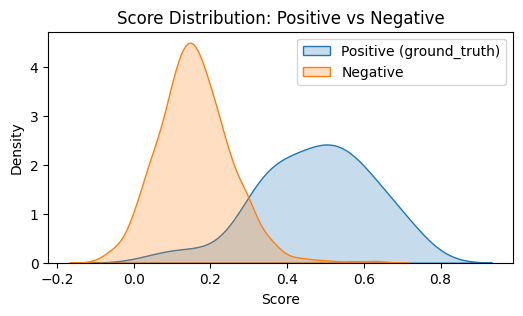

In [ ]:
# Plot score distributions
plt.figure(figsize=(6, 3))
sns.kdeplot(positive_scores, label="Positive (ground_truth)", shade=True)
sns.kdeplot(negative_scores, label="Negative", shade=True)
plt.xlabel("Score")
plt.ylabel("Density")
plt.title("Score Distribution: Positive vs Negative")
plt.legend()
plt.show()

* These is an overlap between the 2 population, which can explain poor  retrieval performance

In [ ]:
# Find best threshold using ROC analysis
labels = [1] * len(positive_scores) + [0] * len(negative_scores)
scores = positive_scores + negative_scores

fpr, tpr, thresholds = roc_curve(labels, scores)
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]

print(f"Best threshold (Youden's J): {best_threshold:.4f}")

# # ROC curve
# plt.figure(figsize=(6, 3))
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.plot([0, 1], [0, 1], '--', color='gray')
# plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.show()

Best threshold (Youden's J): 0.3207


## Eval Top-K with Threshold on Test set

In [ ]:
metrics_df_base = evaluate_retrieval_multi_k_df(df_test, k_values=[1, 2, 3, 5, 7, 10])
metrics_df_base = metrics_df_base.set_index('top_k')
metrics_df_base

,recall,precision,hit,MAP,MRR
top_k,,,,,
1,0.464286,0.700000,0.7,0.464286,0.700
2,0.695238,0.600000,0.9,0.636905,0.800
3,0.711905,0.433333,0.9,0.648016,0.800
5,0.873810,0.360000,1.0,0.720992,0.825
7,0.888095,0.271429,1.0,0.731196,0.825
10,0.902381,0.200000,1.0,0.739768,0.825


In [ ]:
metrics_df_th = evaluate_retrieval_multi_k_df(df_test, k_values=[1, 2, 3, 5, 7, 10], threshold=best_threshold)
metrics_df_th = metrics_df_th.set_index('top_k')
metrics_df_th

,recall,precision,hit,MAP,MRR
top_k,,,,,
1,0.464286,0.700000,0.7,0.464286,0.700
2,0.695238,0.600000,0.9,0.636905,0.800
3,0.711905,0.433333,0.9,0.648016,0.800
5,0.873810,0.360000,1.0,0.720992,0.825
7,0.873810,0.257143,1.0,0.720992,0.825
10,0.873810,0.180000,1.0,0.720992,0.825


* The metrices did not improved when adding a threshold
* This could be as a results of:
  - the embedding / indexing method is not that good - there is no clear seperation between positive and negative pairs
  - the validation group used is samll and not representing the population

# Apply Function

In [ ]:
TOP_K = 3
THRESHOLD = best_threshold

def search(question):
  docs, score = get_docs_similarity(question, df_indexing)
  mask = score >= THRESHOLD
  if mask.any():
    filtered_docs = [doc for doc, keep in zip(docs, mask) if keep]
    filtered_docs = filtered_docs[:TOP_K]
  else:
    filtered_docs = docs[0]
  return filtered_docs

## Test on a random question

In [ ]:
sample_question = df_questions.sample(1).iloc[0]
query_text = sample_question['question']
ground_truth_docs = sample_question['doc_ids']
print(f"Question:\n {query_text}")
print(f"Ground Truth Docs:\n {ground_truth_docs}")

Question:
 Why are users failing to match access roles?
Ground Truth Docs:
 ['sk115776', 'sk101524', 'sk63943']


In [ ]:
search(query_text)

['sk63943', 'sk101524', 'sk115776']

# Next Steps

* Improve embedding -
  * Test for othere SBERT model
  * Test if there are pre-trained models that are more relevant for the current doamin
  * Clean text - documents might contains some parts that are irrelevant and adding noise to the data; check by domain experts if the documents can be cleaned for better representation using specific rules; another option is to use summarization method;
* Combination of dense vector and words frequency embedding methods, might improve perfromance in case technichal / specific domain words are used